Kolmogorov-Arnold Network는 Kolmogorov-Arnold representation theorem에서 기초한 것으로, `연속적인 다변량 함수를 일변수 함수의 합성으로 표한할 수 있음`을 전제함

이를 수식으로 표현하면 아래와 같음

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
# 콜모고로프-아르놀드 정리 수식 표시
equation = r"""
\displaystyle f(x_1, x_2, \dots, x_n) = \sum_{q=1}^{2n+1} \phi_q\left( \sum_{p=1}^n \psi_p(x_p) + c_q \right)
"""
display(Math(equation))

<IPython.core.display.Math object>

In [4]:
# 근사하려는 실제 함수 수식 표시
equation = r"""
\displaystyle f(x_1, x_2) = \sin(x_1 + x_2)
"""
display(Math(equation))

<IPython.core.display.Math object>

In [ ]:
# 입력 데이터 생성
x1 = np.linspace(-2*np.pi, 2*np.pi, 200)
x2 = np.linspace(-2*np.pi, 2*np.pi, 200)
X1, X2 = np.meshgrid(x1, x2)

# 입력 데이터를 벡터 형태로 변환
X_input = np.stack([X1.flatten(), X2.flatten()], axis=1)

# 실제 함수 값 계산
def f_true(x):
    return np.sin(x[:, 0] + x[:, 1])

Y_true = f_true(X_input)

In [6]:
# 데이터를 PyTorch 텐서로 변환
X_tensor = torch.tensor(X_input, dtype=torch.float32)
Y_tensor = torch.tensor(Y_true.reshape(-1, 1), dtype=torch.float32)

In [7]:
# 신경망 모델 정의
class KolmogorovArnoldNet(nn.Module):
    def __init__(self, n_input):
        super(KolmogorovArnoldNet, self).__init__()
        n_hidden = 2 * n_input + 1  # 은닉층 뉴런 수
        self.fc1 = nn.Linear(n_input, n_hidden)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(n_hidden, 1)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

# 모델 인스턴스 생성
model = KolmogorovArnoldNet(n_input=2)
print(model)

KolmogorovArnoldNet(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (activation): Tanh()
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)


In [11]:
# 손실 함수와 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 에포크별로 결과를 저장하기 위한 리스트
epochs_to_save = [0, 9, 49, 99]
outputs = []
loss_history = []
num_epochs = 100


In [12]:
# 모델 학습
for epoch in range(num_epochs):
    model.train()
    
    # 순전파
    outputs_pred = model(X_tensor)
    loss = criterion(outputs_pred, Y_tensor)
    
    # 역전파 및 최적화
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 손실 저장
    loss_history.append(loss.item())
    
    # 에포크별 결과 저장
    if epoch in epochs_to_save:
        with torch.no_grad():
            model.eval()
            Y_pred = model(X_tensor).detach().numpy()
            outputs.append((epoch, Y_pred))
    
    # 진행 상황 출력
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

Epoch [10/100], Loss: 0.378616
Epoch [20/100], Loss: 0.359824
Epoch [30/100], Loss: 0.345000
Epoch [40/100], Loss: 0.332773
Epoch [50/100], Loss: 0.319930
Epoch [60/100], Loss: 0.300796
Epoch [70/100], Loss: 0.284550
Epoch [80/100], Loss: 0.267709
Epoch [90/100], Loss: 0.256210
Epoch [100/100], Loss: 0.246521


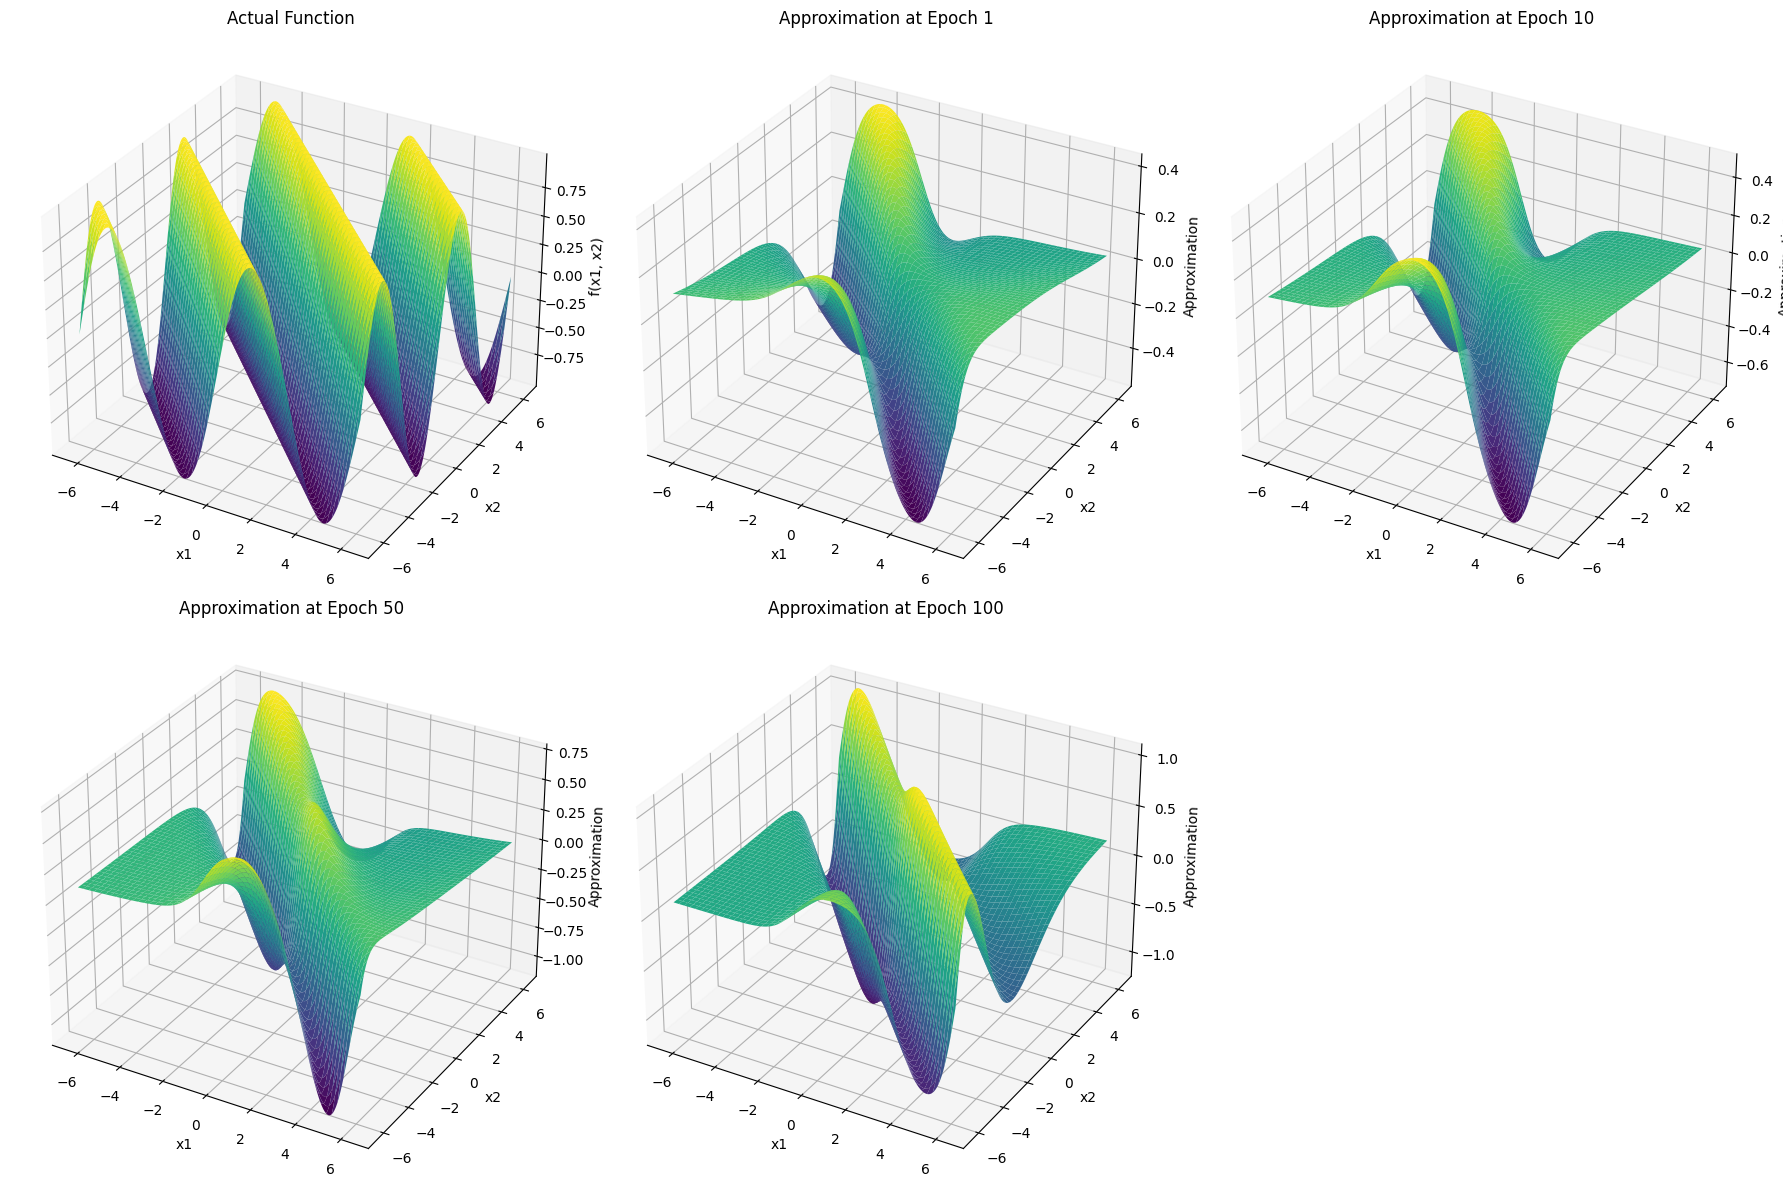

In [13]:
# 에포크별 결과 시각화 함수 정의
def plot_approximations_torch(X1, X2, Y_true, outputs):
    fig = plt.figure(figsize=(18, 12))

    # 실제 함수 시각화
    ax = fig.add_subplot(2, 3, 1, projection='3d')
    ax.plot_surface(X1, X2, Y_true.reshape(X1.shape), cmap='viridis')
    ax.set_title('Actual Function')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f(x1, x2)')

    # 에포크별 근사 결과 시각화
    for i, (epoch, Y_pred) in enumerate(outputs):
        ax = fig.add_subplot(2, 3, i+2, projection='3d')
        ax.plot_surface(X1, X2, Y_pred.reshape(X1.shape), cmap='viridis')
        ax.set_title(f'Approximation at Epoch {epoch+1}')
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('Approximation')

    plt.tight_layout()
    plt.show()

plot_approximations_torch(X1, X2, Y_true, outputs)


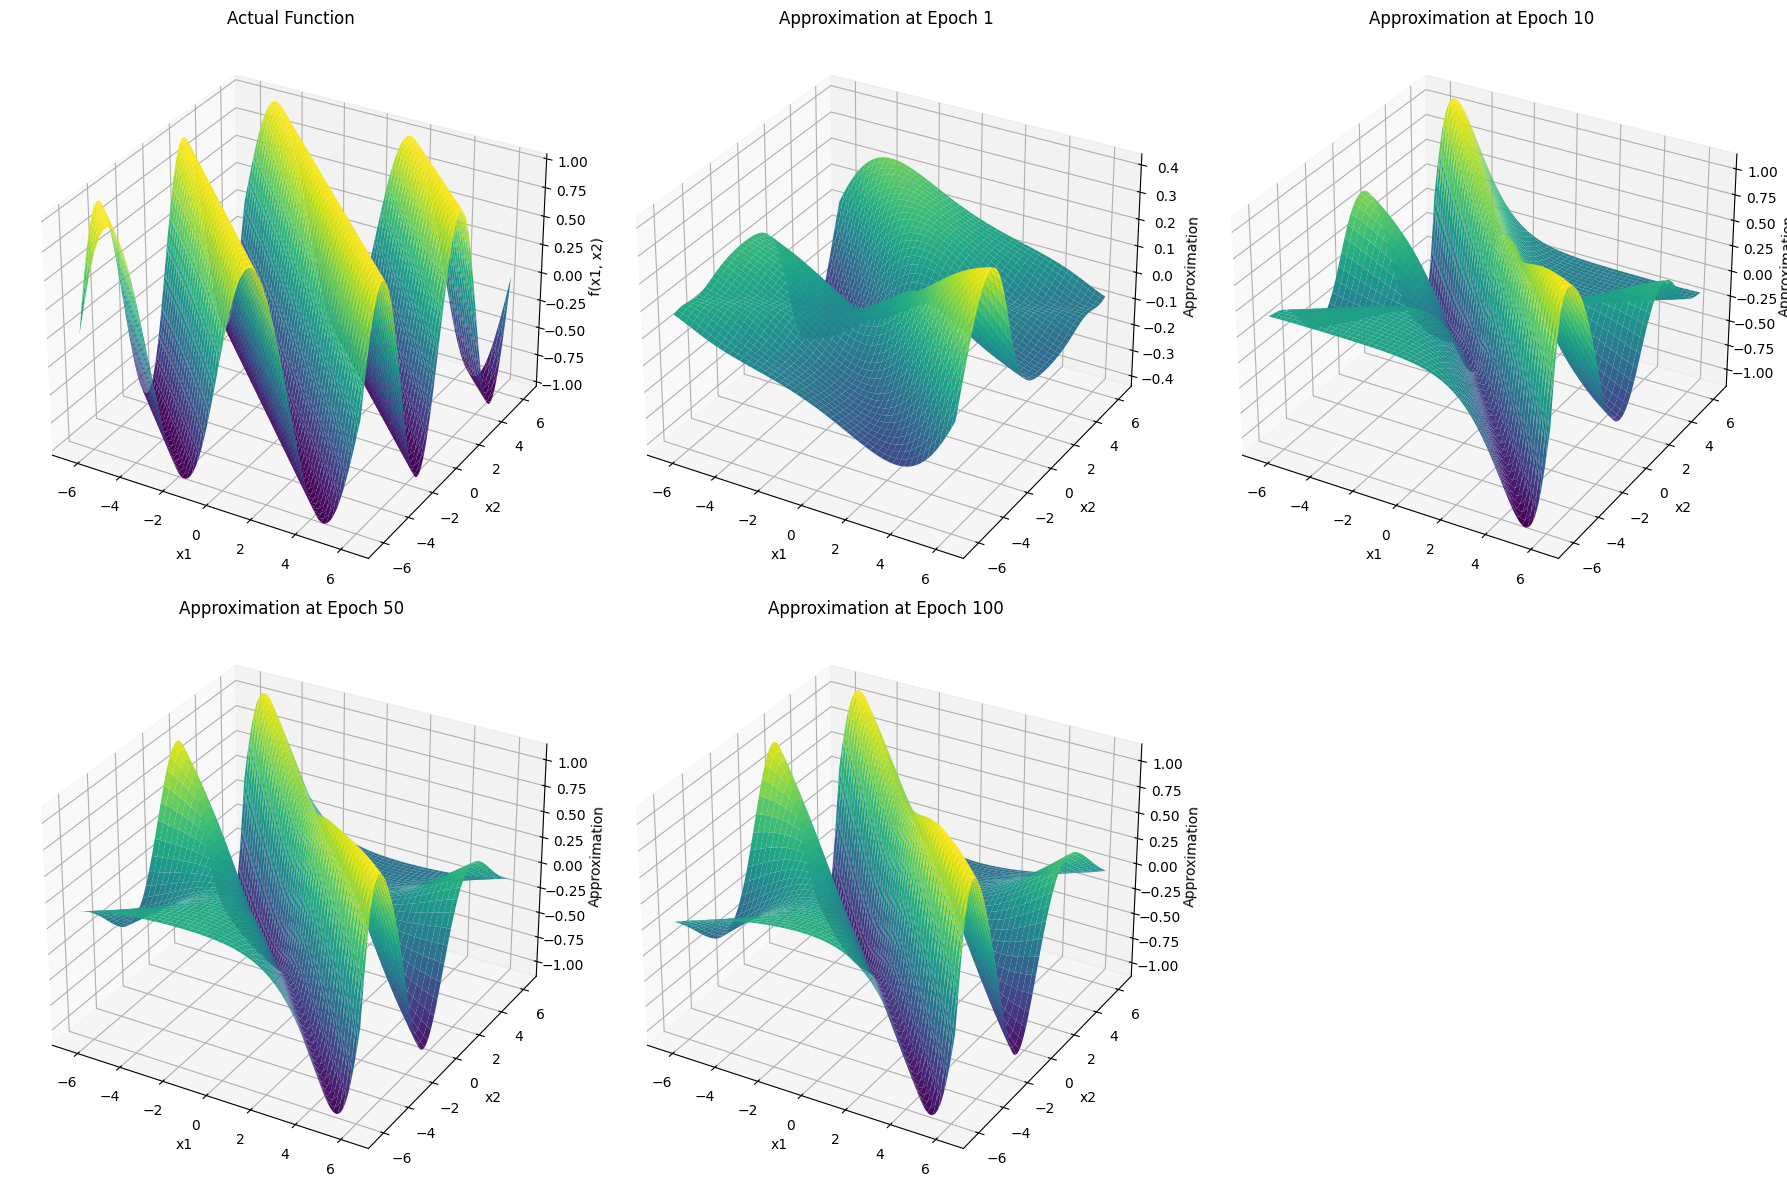

In [14]:
# 에포크별 결과 시각화 함수 정의
def plot_approximations(X1, X2, Y_true, saver):
    fig = plt.figure(figsize=(18, 12))

    # 실제 함수 시각화
    ax = fig.add_subplot(2, 3, 1, projection='3d')
    ax.plot_surface(X1, X2, Y_true.reshape(X1.shape), cmap='viridis')
    ax.set_title('Actual Function')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('f(x1, x2)')

    # 에포크별 근사 결과 시각화
    for i, (epoch, Y_pred) in enumerate(saver.outputs):
        ax = fig.add_subplot(2, 3, i+2, projection='3d')
        ax.plot_surface(X1, X2, Y_pred.reshape(X1.shape), cmap='viridis')
        ax.set_title(f'Approximation at Epoch {epoch+1}')
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_zlabel('Approximation')

    plt.tight_layout()
    plt.show()

plot_approximations(X1, X2, Y_true, saver)
